# Comprehensive Guide to Creating Convergence Plots

This notebook provides a step-by-step guide to creating, analyzing, and customizing convergence plots for numerical methods. You'll learn how to:

1. Generate basic convergence plots
2. Compare different convergence rates
3. Apply advanced visualization techniques
4. Create publication-quality figures

Let's get started!

## 1. Base Code for Convergence Plotting

In this section, we'll develop the foundation for generating and plotting convergence data. We'll start by importing necessary libraries and creating functions to simulate convergence behaviors.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# For nicer plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.5)

# Set random seed for reproducibility
np.random.seed(42)

### Generate Synthetic Convergence Data

First, let's create functions to generate synthetic data representing different types of convergence behavior:

- Linear convergence: Error reduces by a constant factor each iteration
- Quadratic convergence: Error is squared each iteration (superlinear)
- Sublinear convergence: Error reduces slower than a constant factor

In [2]:
def generate_convergence_data(n_iterations=30, convergence_type='linear', noise_level=0.1,
                             initial_error=1.0):
    """
    Generate synthetic convergence data with optional noise.
    
    Parameters:
    -----------
    n_iterations : int
        Number of iterations to simulate
    convergence_type : str
        Type of convergence: 'linear', 'quadratic', or 'sublinear'
    noise_level : float
        Amount of noise to add (as a fraction of the error)
    initial_error : float
        Starting error value
    
    Returns:
    --------
    iterations : numpy array
        Iteration indices
    errors : numpy array
        Error values at each iteration
    """
    iterations = np.arange(n_iterations)
    
    if convergence_type == 'linear':
        # Error reduces by a factor of 0.5 each iteration (linear convergence)
        errors = initial_error * (0.5 ** iterations)
    elif convergence_type == 'quadratic':
        # Error is squared each iteration (quadratic convergence)
        errors = initial_error * (0.5 ** (2 ** iterations))
    elif convergence_type == 'sublinear':
        # Error reduces more slowly (sublinear convergence)
        errors = initial_error * (1.0 / (iterations + 1))
    else:
        raise ValueError(f"Unknown convergence type: {convergence_type}")
    
    # Add some noise
    if noise_level > 0:
        noise = np.random.normal(0, noise_level, n_iterations) * errors
        errors = np.maximum(errors + noise, 1e-16)  # Ensure errors remain positive
        
    return iterations, errors

### Basic Convergence Plot

Now let's create a basic function for plotting convergence data:

In [3]:
def plot_convergence(iterations, errors, title="Convergence Plot", 
                    xlabel="Iteration", ylabel="Error", scale='semilogy'):
    """
    Create a basic convergence plot.
    
    Parameters:
    -----------
    iterations : array-like
        Iteration indices
    errors : array-like
        Error values
    title : str
        Plot title
    xlabel, ylabel : str
        Axis labels
    scale : str
        Plot scale: 'semilogy', 'semilogx', 'loglog', or 'linear'
    """
    plt.figure(figsize=(10, 6))
    
    if scale == 'semilogy':
        plt.semilogy(iterations, errors, 'o-', linewidth=2)
    elif scale == 'semilogx':
        plt.semilogx(iterations, errors, 'o-', linewidth=2)
    elif scale == 'loglog':
        plt.loglog(iterations, errors, 'o-', linewidth=2)
    else:  # linear
        plt.plot(iterations, errors, 'o-', linewidth=2)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, which="both", ls="-")
    plt.tight_layout()
    
    return plt.gca()

### Example: Linear Convergence

Let's generate and plot some basic linear convergence data:

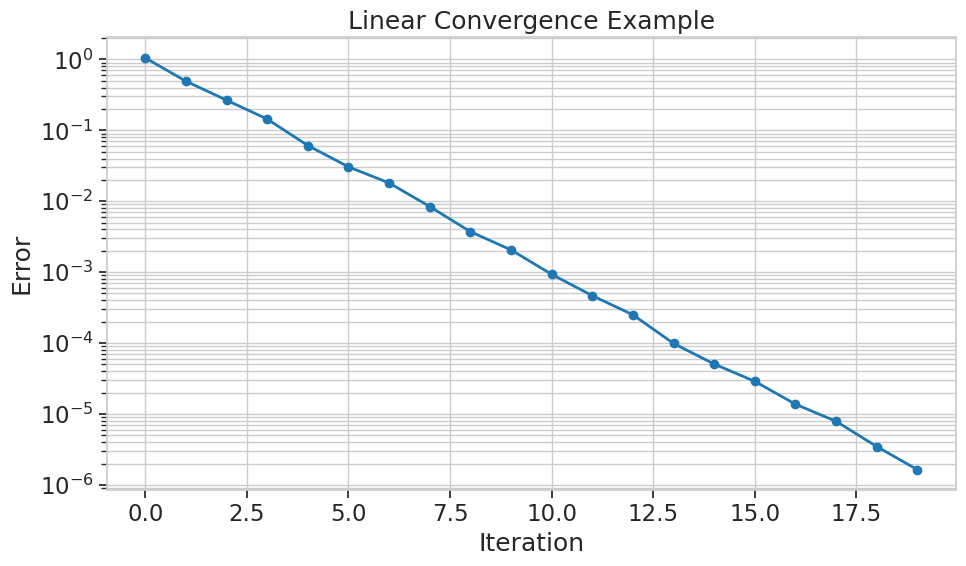

,Iteration,Error
0,0,1.049671
1,1,0.493087
2,2,0.266192
3,3,0.144038
4,4,0.061037
5,5,0.030518
6,6,0.018093
7,7,0.008412
8,8,0.003723
9,9,0.002059


In [4]:
# Generate linear convergence data
iterations, errors = generate_convergence_data(n_iterations=20, convergence_type='linear')

# Plot the data
plot_convergence(iterations, errors, "Linear Convergence Example")
plt.show()

# Print the first few values
pd.DataFrame({'Iteration': iterations[:10], 'Error': errors[:10]}).round(8)

Notice how the error decreases exponentially on this semi-log plot, appearing as a straight line. This is characteristic of linear convergence, where each iteration reduces the error by a constant factor.

## 2. Comparison of Different Convergence Types

In this section, we'll visualize different types of convergence behaviors side by side to understand their characteristics.

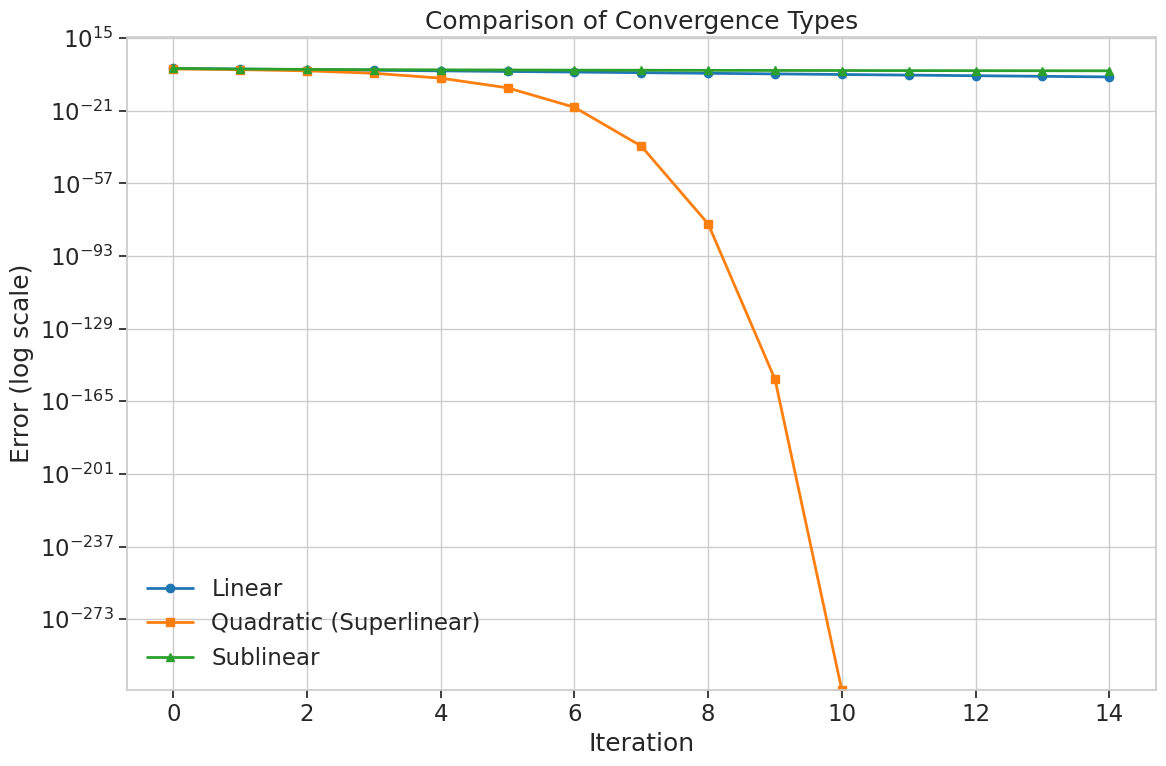

In [5]:
# Generate different convergence data types
iterations_linear, errors_linear = generate_convergence_data(
    n_iterations=15, convergence_type='linear', initial_error=1.0, noise_level=0.0)

iterations_quadratic, errors_quadratic = generate_convergence_data(
    n_iterations=15, convergence_type='quadratic', initial_error=1.0, noise_level=0.0)

iterations_sublinear, errors_sublinear = generate_convergence_data(
    n_iterations=15, convergence_type='sublinear', initial_error=1.0, noise_level=0.0)

# Create comparison plot
plt.figure(figsize=(12, 8))
plt.semilogy(iterations_linear, errors_linear, 'o-', linewidth=2, label='Linear')
plt.semilogy(iterations_quadratic, errors_quadratic, 's-', linewidth=2, label='Quadratic (Superlinear)')
plt.semilogy(iterations_sublinear, errors_sublinear, '^-', linewidth=2, label='Sublinear')

plt.title("Comparison of Convergence Types")
plt.xlabel("Iteration")
plt.ylabel("Error (log scale)")
plt.grid(True, which="both", ls="-")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Analyzing Convergence Rates

To better understand the different convergence behaviors, let's compute and visualize the convergence rates.

The convergence rate represents how quickly the error decreases from one iteration to the next. 
For a sequence of errors $\{e_k\}$, the convergence rate $r$ is estimated by:

$e_{k+1} \approx C \cdot e_k^r$

Where:
- $r = 1$ indicates linear convergence
- $r > 1$ indicates superlinear convergence (e.g., $r = 2$ for quadratic)
- $r < 1$ indicates sublinear convergence

We can estimate $r$ by computing:

$r \approx \frac{\log(e_{k+1}/e_{k+2})}{\log(e_k/e_{k+1})}$

In [6]:
def estimate_convergence_rate(errors):
    """
    Estimate the convergence rate from a sequence of error values.
    
    Parameters:
    -----------
    errors : array-like
        Sequence of error values
        
    Returns:
    --------
    rates : numpy array
        Estimated convergence rates
    """
    # Need at least 3 points to compute rate
    if len(errors) < 3:
        return np.array([])
    
    # Compute log ratios
    log_ratios = np.log(errors[:-1] / errors[1:] + 1e-16)  # add small epsilon to avoid division by zero
    
    # Estimate rates
    rates = np.zeros(len(errors) - 2)
    for i in range(len(rates)):
        if log_ratios[i] > 1e-10:  # Avoid division by very small numbers
            rates[i] = log_ratios[i+1] / log_ratios[i]
        else:
            rates[i] = np.nan
            
    return rates

/tmp/ipykernel_15185/2959133145.py:20: RuntimeWarning: divide by zero encountered in divide
  log_ratios = np.log(errors[:-1] / errors[1:] + 1e-16)  # add small epsilon to avoid division by zero
/tmp/ipykernel_15185/2959133145.py:20: RuntimeWarning: invalid value encountered in divide
  log_ratios = np.log(errors[:-1] / errors[1:] + 1e-16)  # add small epsilon to avoid division by zero


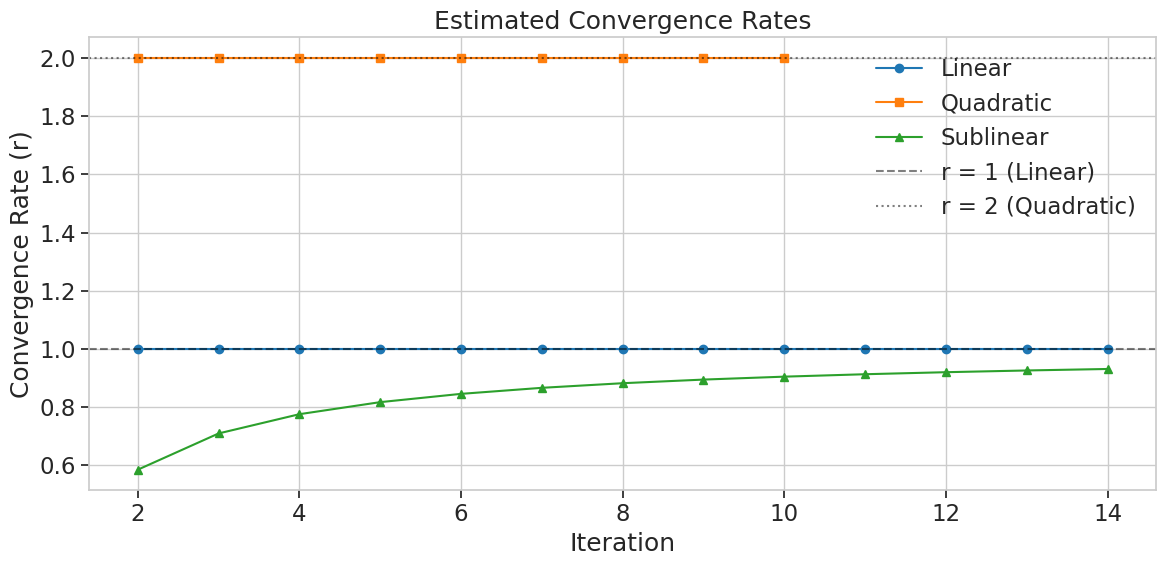

In [7]:
# Calculate convergence rates
rates_linear = estimate_convergence_rate(errors_linear)
rates_quadratic = estimate_convergence_rate(errors_quadratic)
rates_sublinear = estimate_convergence_rate(errors_sublinear)

# Plot the rates
plt.figure(figsize=(12, 6))

plt.plot(range(2, len(errors_linear)), rates_linear, 'o-', label='Linear')
plt.plot(range(2, len(errors_quadratic)), rates_quadratic, 's-', label='Quadratic')
plt.plot(range(2, len(errors_sublinear)), rates_sublinear, '^-', label='Sublinear')

plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='r = 1 (Linear)')
plt.axhline(y=2.0, color='k', linestyle=':', alpha=0.5, label='r = 2 (Quadratic)')

plt.title("Estimated Convergence Rates")
plt.xlabel("Iteration")
plt.ylabel("Convergence Rate (r)")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Advanced Convergence Plotting Techniques

In this section, we'll explore more advanced techniques for analyzing and visualizing convergence data.

### Multiple Subplots for Comprehensive Analysis

Using multiple subplots can help us visualize different aspects of convergence simultaneously.

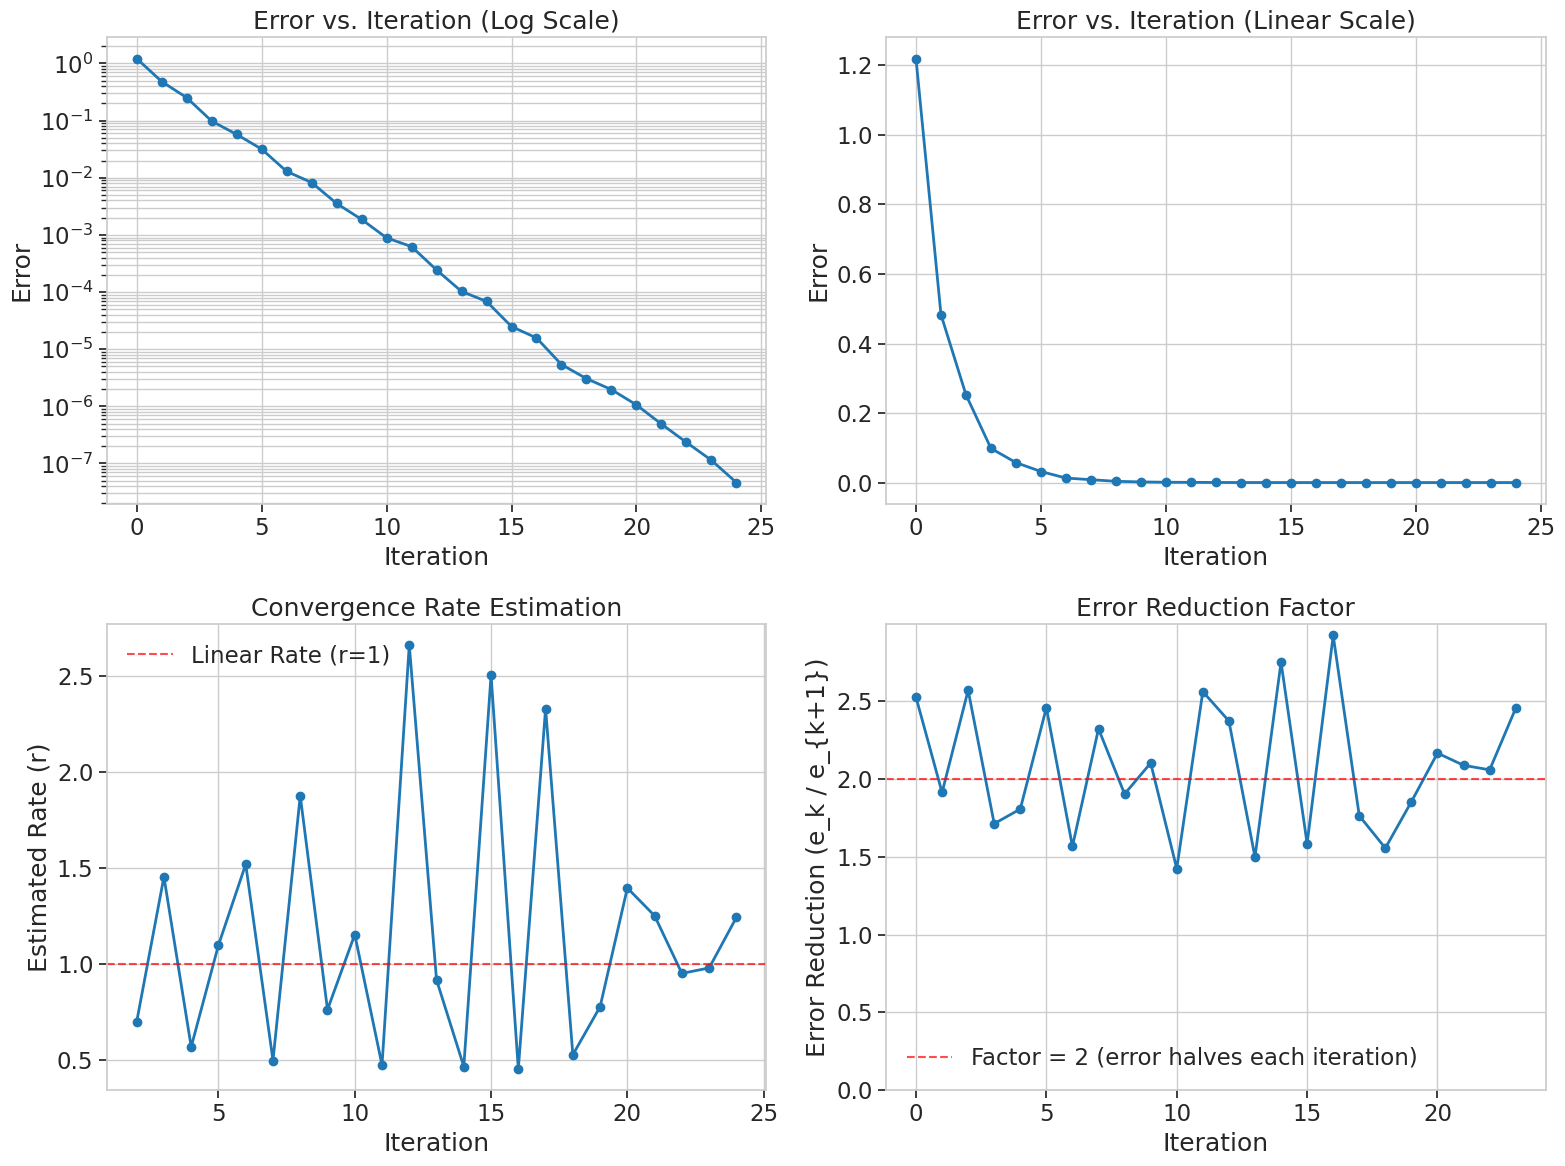

In [8]:
# Generate convergence data with some noise
iterations, errors = generate_convergence_data(
    n_iterations=25, convergence_type='linear', noise_level=0.15)

# Calculate convergence rates
rates = estimate_convergence_rate(errors)

# Calculate error reduction per iteration
error_reduction = errors[:-1] / errors[1:]

# Create a 2x2 subplot for comprehensive analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Error vs. Iteration (semilogy)
axes[0, 0].semilogy(iterations, errors, 'o-', linewidth=2)
axes[0, 0].set_title("Error vs. Iteration (Log Scale)")
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].set_ylabel("Error")
axes[0, 0].grid(True, which="both")

# Plot 2: Error vs. Iteration (linear)
axes[0, 1].plot(iterations, errors, 'o-', linewidth=2)
axes[0, 1].set_title("Error vs. Iteration (Linear Scale)")
axes[0, 1].set_xlabel("Iteration")
axes[0, 1].set_ylabel("Error")
axes[0, 1].grid(True)

# Plot 3: Convergence Rate
axes[1, 0].plot(range(2, len(errors)), rates, 'o-', linewidth=2)
axes[1, 0].axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Linear Rate (r=1)')
axes[1, 0].set_title("Convergence Rate Estimation")
axes[1, 0].set_xlabel("Iteration")
axes[1, 0].set_ylabel("Estimated Rate (r)")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Error Reduction Factor
axes[1, 1].plot(iterations[:-1], error_reduction, 'o-', linewidth=2)
axes[1, 1].axhline(y=2.0, color='r', linestyle='--', alpha=0.7, 
                  label='Factor = 2 (error halves each iteration)')
axes[1, 1].set_title("Error Reduction Factor")
axes[1, 1].set_xlabel("Iteration")
axes[1, 1].set_ylabel("Error Reduction (e_k / e_{k+1})")
axes[1, 1].set_ylim(bottom=0)
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

### Convergence Map for Parameter Studies

When studying how a method's convergence depends on certain parameters, we can use heatmaps to visualize the relationship.

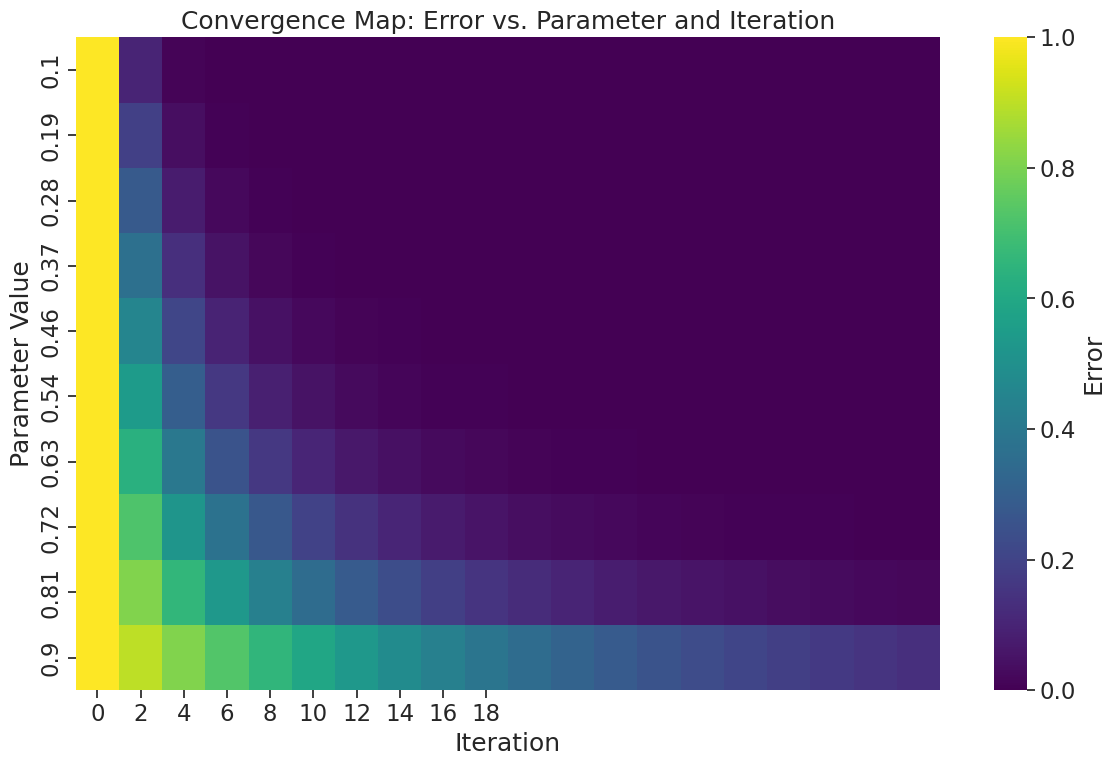

In [9]:
# Generate data for a parameter study (convergence vs. parameter value)
param_values = np.linspace(0.1, 0.9, 10)  # Different parameter values
n_iterations = 20

# Store final errors for each parameter value
convergence_map = np.zeros((len(param_values), n_iterations))

for i, param in enumerate(param_values):
    # Generate data with convergence rate dependent on the parameter
    # (here we're simulating different linear convergence rates)
    iterations = np.arange(n_iterations)
    convergence_map[i, :] = (param ** iterations)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(convergence_map, cmap="viridis", 
           xticklabels=np.arange(0, n_iterations, 2),
           yticklabels=np.round(param_values, 2),
           cbar_kws={'label': 'Error'})

plt.title("Convergence Map: Error vs. Parameter and Iteration")
plt.xlabel("Iteration")
plt.ylabel("Parameter Value")
plt.tight_layout()
plt.show()

### 3D Surface Plot for Convergence Analysis

For a more detailed view of how parameters affect convergence, we can use 3D surface plots.

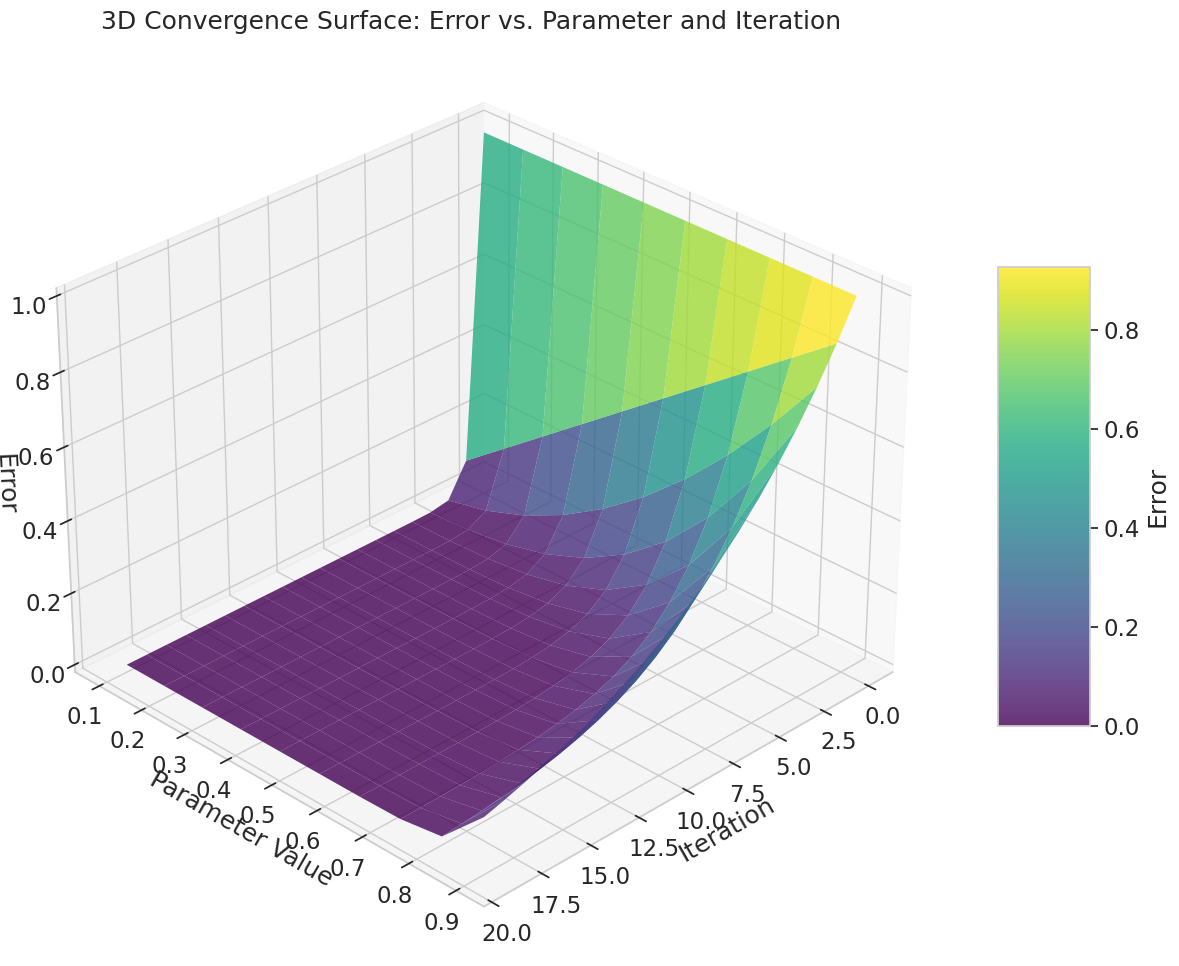

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Create data for 3D visualization
X, Y = np.meshgrid(np.arange(n_iterations), param_values)

# Create 3D surface plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, convergence_map, cmap='viridis', edgecolor='none', alpha=0.8)

ax.set_title("3D Convergence Surface: Error vs. Parameter and Iteration")
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter Value")
ax.set_zlabel("Error")
ax.view_init(elev=30, azim=45)  # Adjust viewing angle

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label="Error")

plt.tight_layout()
plt.show()

## 4. Convergence Plot Customization for Publication

In this section, we'll focus on creating publication-quality convergence plots with proper annotations, styling, and layout.

ValueError: Integers to negative integer powers are not allowed.

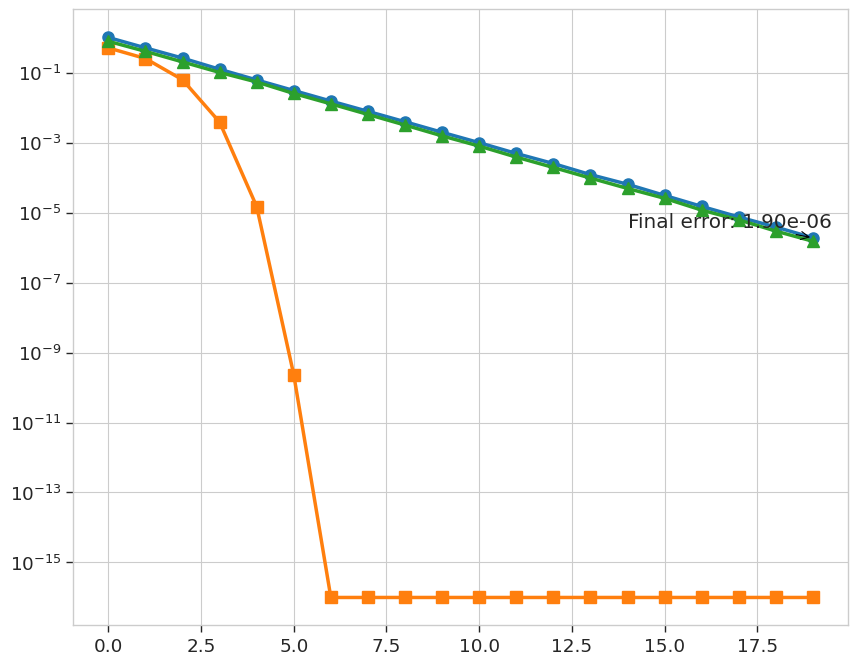

In [13]:
# Set the plotting style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Generate convergence data for different methods
methods = {
    "Method A": generate_convergence_data(n_iterations=20, convergence_type='linear', 
                                         initial_error=1.0, noise_level=0.02),
    "Method B": generate_convergence_data(n_iterations=20, convergence_type='quadratic', 
                                         initial_error=1.0, noise_level=0.02),
    "Method C": generate_convergence_data(n_iterations=20, convergence_type='linear', 
                                         initial_error=0.8, noise_level=0.02)
}

# Create a publication-ready plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each method with distinct markers and colors
markers = ['o', 's', '^', 'd']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (method_name, (iterations, errors)) in enumerate(methods.items()):
    ax.semilogy(iterations, errors, marker=markers[i], color=colors[i], 
               linestyle='-', markersize=8, label=method_name)
    
    # Annotate the final error point
    if i == 0:  # Only annotate the first method to avoid clutter
        ax.annotate(f'Final error: {errors[-1]:.2e}',
                   xy=(iterations[-1], errors[-1]),
                   xytext=(iterations[-1]-5, errors[-1]*2),
                   arrowprops=dict(arrowstyle='->'))

# Add a theoretical slope for comparison
x_theory = np.arange(5, 15)
y_theory = 10**(-x_theory)
ax.semilogy(x_theory, y_theory, 'k--', alpha=0.7, label='Order 1 (theoretical)')

# Customize the plot
ax.set_title("Convergence Comparison of Different Methods", fontsize=18, pad=15)
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Error (log scale)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which="both", ls="-", alpha=0.7)

# Set y-axis limits to focus on relevant error range
ax.set_ylim(1e-10, 2)

# Add a legend with shadow and rounded corners
legend = ax.legend(loc='upper right', shadow=True, fontsize=14, frameon=True, 
                  framealpha=0.95, fancybox=True)
frame = legend.get_frame()
frame.set_edgecolor('gray')

# Adjust the tick marks
ax.tick_params(direction='in', length=6, width=1.5, grid_alpha=0.7)

# Add a text box with additional information
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.05, 'Simulation parameters:\n- 20 iterations\n- Initial error: 1.0',
        transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

# Add a grid to the minor ticks on the log scale
ax.grid(which='minor', alpha=0.3)

plt.tight_layout()
plt.show()

### Subplots with Shared Axes for Method Comparison

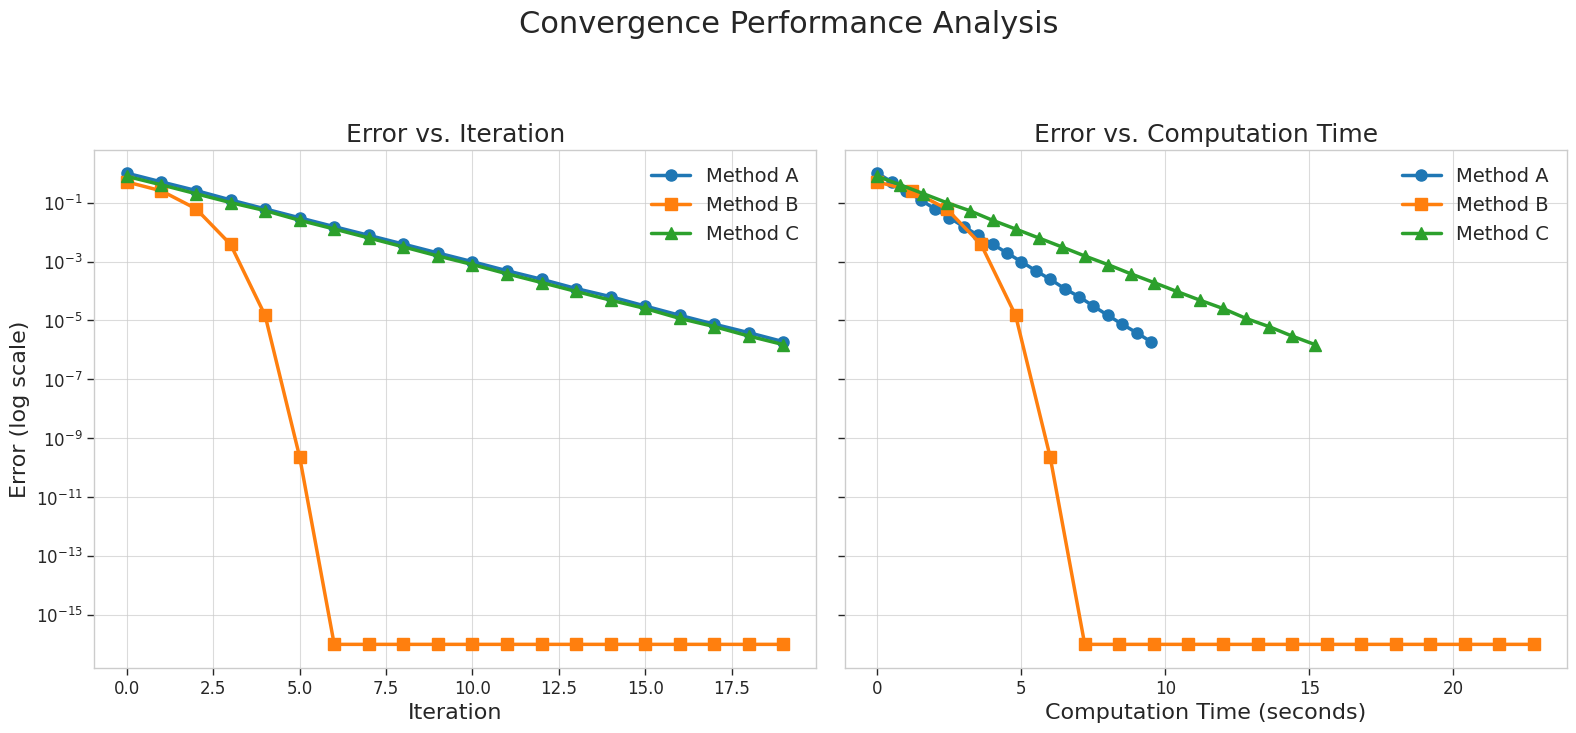

In [14]:
# Create a figure with shared axes
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Left plot: Error vs. Iteration
for i, (method_name, (iterations, errors)) in enumerate(methods.items()):
    axes[0].semilogy(iterations, errors, marker=markers[i], color=colors[i], 
                    linestyle='-', markersize=8, label=method_name)

axes[0].set_title("Error vs. Iteration", fontsize=18)
axes[0].set_xlabel("Iteration", fontsize=16)
axes[0].set_ylabel("Error (log scale)", fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(True, which="both", ls="-", alpha=0.7)
axes[0].legend(loc='upper right', fontsize=14)

# Right plot: Error vs. Computation Time (simulated)
# Simulate different computation times per iteration for each method
comp_time_per_iter = {"Method A": 0.5, "Method B": 1.2, "Method C": 0.8}

for i, (method_name, (iterations, errors)) in enumerate(methods.items()):
    # Create simulated cumulative computation time
    cum_time = np.array(iterations) * comp_time_per_iter[method_name]
    axes[1].semilogy(cum_time, errors, marker=markers[i], color=colors[i], 
                    linestyle='-', markersize=8, label=method_name)

axes[1].set_title("Error vs. Computation Time", fontsize=18)
axes[1].set_xlabel("Computation Time (seconds)", fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(True, which="both", ls="-", alpha=0.7)
axes[1].legend(loc='upper right', fontsize=14)

# Add an overall title
fig.suptitle("Convergence Performance Analysis", fontsize=22, y=1.05)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

### Export High-Resolution Figures for Publication

For publication purposes, it's important to save figures in high resolution and with the appropriate format.

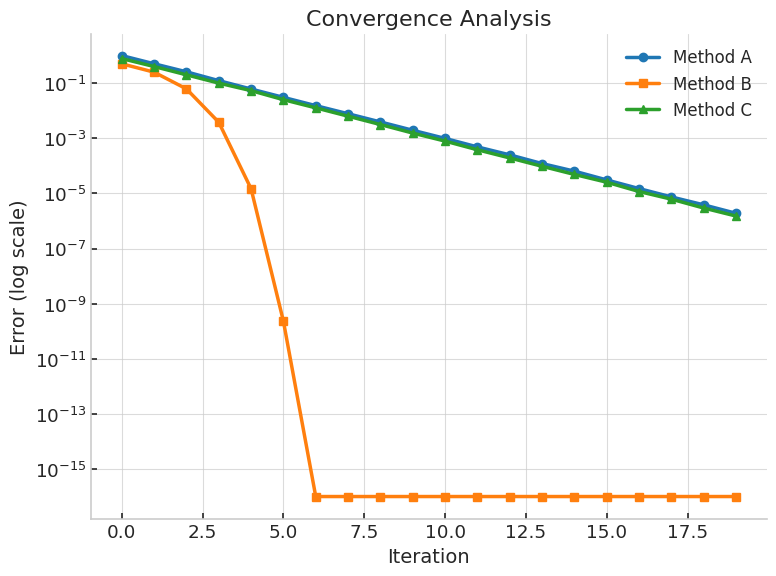

In [15]:
# Create a publication-ready figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot with customized styles
for i, (method_name, (iterations, errors)) in enumerate(methods.items()):
    ax.semilogy(iterations, errors, marker=markers[i], color=colors[i], 
               linestyle='-', markersize=6, label=method_name)

# Customize the plot
ax.set_title("Convergence Analysis", fontsize=16)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_ylabel("Error (log scale)", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, which="both", ls="-", alpha=0.7)

# Improve the appearance for publication
ax.tick_params(direction='in', length=4, width=1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()

# Uncomment to save as high-resolution PDF (vector format)
# plt.savefig('convergence_analysis.pdf', format='pdf', dpi=600, bbox_inches='tight')

# Uncomment to save as high-resolution PNG
# plt.savefig('convergence_analysis.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

## Conclusion

In this notebook, we've covered comprehensive techniques for creating and customizing convergence plots:

1. **Base code** for generating and plotting convergence data
2. **Comparison** of different convergence behaviors (linear, superlinear, sublinear)
3. **Advanced techniques** including 3D visualization, parameter studies, and convergence rate estimation
4. **Publication-quality customization** with proper styling, annotations, and multiple visualization approaches

These tools and techniques should provide a solid foundation for visualizing and analyzing convergence behavior in your own numerical methods and algorithms.